<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# MTBS Fire Modeling Demo

_by Jeremy Freeman (CarbonPlan), September 19, 2020_

This notebook loads munged, downsampled MTBS fire data and TerraClimate climate data and fits a simple logistical regression model.

Before getting started you'll need to download this file: https://storage.googleapis.com/carbonplan-data/processed/mtbs/conus/16000m/training.pkl. 

A file with the same contents is available in parquet: https://storage.googleapis.com/carbonplan-data/processed/mtbs/conus/16000m/training.parquet.


### Setup

In [1]:
from showit import image
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
warnings.simplefilter(action='ignore', category=RuntimeWarning)
%matplotlib inline

### Load the data

We've already munged the data into two dictionaries: X (with our regressors) and y (with our fire data). We're using the downsampled data for speed and simplicity. At higher resolutions, similar approaches should work, and additional techniques could possibly be included.

In [2]:
with open('data/16000m/training.pkl', 'rb') as f:
    X, y, time, lat, lon = pickle.load(f)

There's one `y` variable `burned_area` and several `X` variables

In [3]:
# add PDSI (annual mean or summer mean, but that might require a complex process model)
# add CWD
# add SPI (annual mean or summer mean)
print(list(X.keys()))

['tmax_max', 'tmax_min', 'tmax_mean', 'tmin_max', 'tmin_min', 'tmin_mean', 'ppt_max', 'ppt_min', 'ppt_sum', 'forested']


For some simple summary statistics, we can look at the spatial distribution of burned area averaged across years

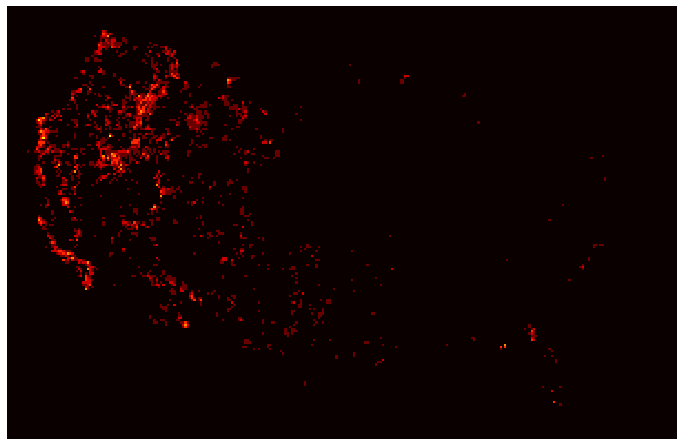

In [4]:
image((y['burned_area'] > 0.05).mean(axis=0), clim=(0, 0.2), cmap='hot', size=12)

Here's the max temperature (max daily maxed across months averaged across years)

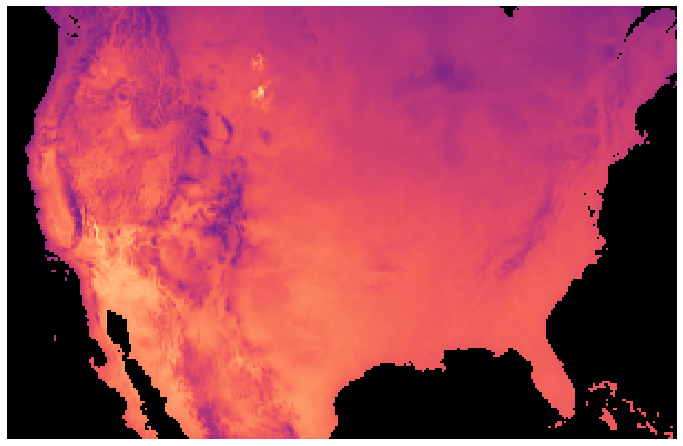

In [5]:
image(X['tmax_max'].mean(axis=0), clim=(0, 50), cmap='magma', size=12)

And here's the fraction of each grid cell that is forested from NLCD

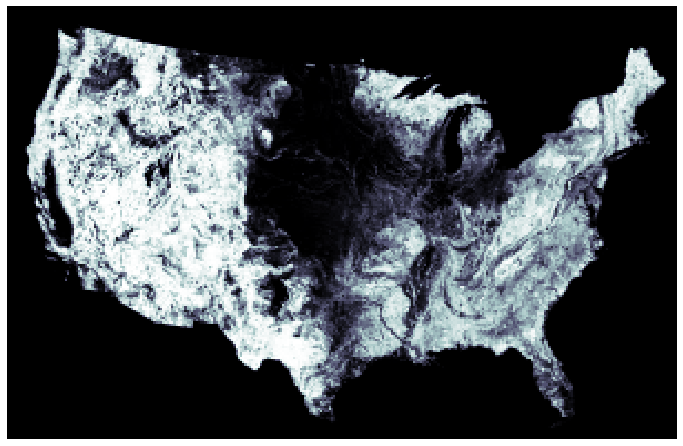

In [6]:
image(X['forested'].mean(axis=0), clim=(0, 1), cmap='bone', size=12)
# consider using the NLFT map here instead

We can also look at dynamics over time avearged across space. We'll make a quick plotting function.

In [7]:
zscore = lambda x: (x - x.mean()) / x.std()

def plot_time_vars(var1, var2):
    y1 = zscore(np.nanmean(X[var1].reshape(len(time), -1), axis=1))
    y2 = zscore(np.nanmean(y[var2].reshape(len(time), -1), axis=1))
    plt.plot(time, y1)
    plt.plot(time, y2)
    plt.legend([var1, var2])
    plt.xlabel('time')
    plt.ylabel(f'{var1} (zscored)')
    plt.figure()
    plt.plot(y1, y2, '.')
    plt.xlabel(var1)
    plt.ylabel(var2);

First we'll look at the positive relationship between maximum temperature and burned area

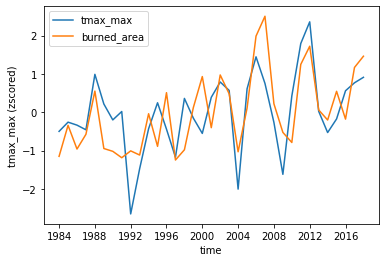

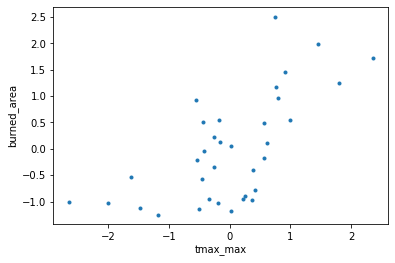

In [8]:
plot_time_vars('tmax_max', 'burned_area')

And now we'll look at the negative relationship with maximum precipitation.

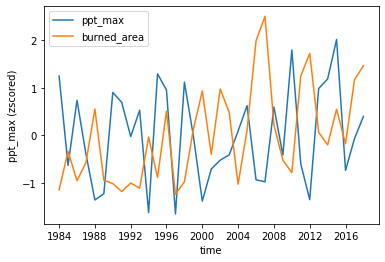

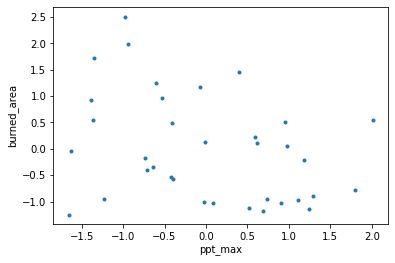

In [9]:
plot_time_vars('ppt_max', 'burned_area')

### Fit a model

Now we build a super simple space-time separable logistic regression model to predict fraction burned as a function of climatic variables.

First we define our dimensions

In [10]:
t = len(time)
n, m = lat.shape

We are going to construct a `(t)(n)(m) x (2v - 1)` design matrix where each of our climatic variables appears twice, once where we have averaged across space and replicated across time, and again where we have averaged across time and replicated across space.

When building the temporal component we skip `forested` because that variable is constant over time.

In [11]:
X_s = np.asarray(
    [np.tile(np.nanmean(X[var], axis=0).flatten(), [1, t]).squeeze() for var in X.keys()]
)

keys = list(X.keys())
keys.remove('forested')
X_t = np.asarray(
    [np.tile(np.nanmean(X[var].reshape(t, n*m), axis=1), [n*m, 1]).T.flatten().squeeze() for var in keys]
).squeeze()

We combine them together to get our full design matrix

In [12]:
X_st = np.vstack([X_s, X_t]).T
print(f'shape: {X_st.shape}')

shape: (2061150, 19)


We turn fraction burned into a binary variable using a threshold, and flatten it

In [13]:
y_b = y['burned_area'].flatten() > 0.05

And we identify all rows that are nans in any of our variables

In [14]:
inds = (~np.isnan(X_st.sum(axis=1))) & (~np.isnan(y_b))

Finally we create a function for zscoring our variables

In [15]:
zscore_2d = lambda x: (x - x.mean(axis=0)) / x.std(axis=0)

Now let's define and fit the model

In [16]:
model = LogisticRegression(fit_intercept = True, max_iter=500, solver='lbfgs')
model.fit(zscore_2d(X_st[inds]), y_b[inds])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's inspect the predictions by computing estimated fraction burned

In [17]:
y_hat = model.predict_proba(zscore_2d(X_st[inds]))[:,1]

We can calculate a quick and dirty ROC score `WARNING NOT CROSS VALIDATED!`

In [18]:
roc_auc_score(y_b[inds], y_hat)

0.9011721477826117

To inspect it visually, we need to reconstitute the full tensor by inverting our NaN removal step

In [19]:
y_hat_full = np.zeros((t, n, m)).flatten()
y_hat_full[inds] = y_hat
y_hat_full = y_hat_full.reshape(t, n, m)

First we'll look at the model's prediction across time

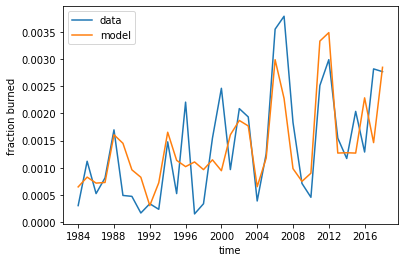

In [20]:
plt.plot(time, np.nanmean(y_b.reshape(t, n*m), axis=1))
plt.plot(time, np.nanmean(y_hat_full.reshape(t, n*m), axis=1))
plt.legend(['data', 'model'])
plt.xlabel('time')
plt.ylabel('fraction burned');

And then we can do the same thing across space

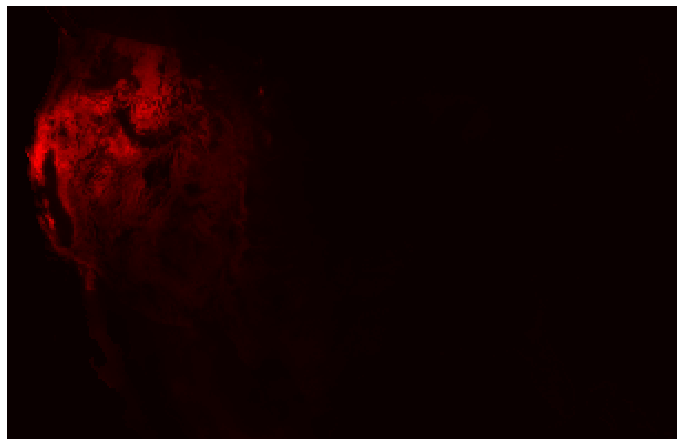

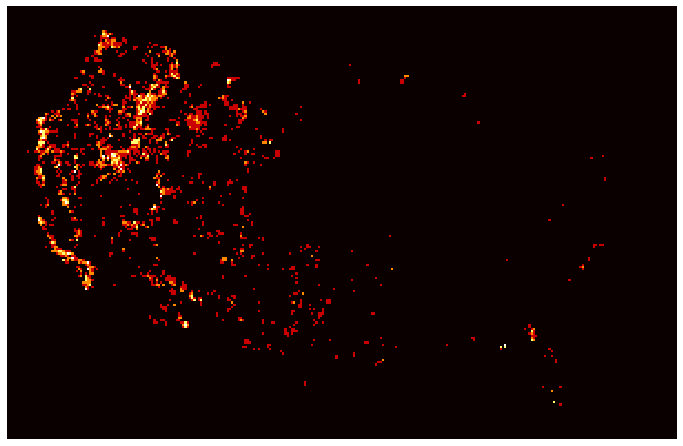

In [22]:
image(np.nanmean(y_hat_full, axis=0), size=12, clim=(0, 0.1), cmap='hot')
image(np.nanmean(y_b.reshape(t, n, m), axis=0), clim=(0, 0.1), cmap='hot', size=12);

Finally, as a sanity check, we can show that if we use only the spatial or temporal component the fit gets worse, and the latter is much worse given that the total dataset varies much more substantially over space than time

In [23]:
model.fit(zscore_2d(X_s.T[inds]), y_b[inds])
y_hat_s = model.predict_proba(zscore_2d(X_s.T[inds]))[:,1]
score_s = roc_auc_score(y_b[inds], y_hat_s)
print(f'spatial only: {score_s}')

spatial only: 0.8886568369734016


In [24]:
model.fit(zscore_2d(X_t.T[inds]), y_b[inds])
y_hat_t = model.predict_proba(zscore_2d(X_t.T[inds]))[:,1]
score_t = roc_auc_score(y_b[inds], y_hat_t)
print(f'temporal only: {score_t}')

temporal only: 0.6509130101184781


### Todo

This was just a demo. Lots more to do! Including:
- Proper performance evaluation and cross validation
- Variable selection
- Exploration of other variables (we have many more)
- Use of models that treat time / space more explicitly (e.g. via spatial kernels and convolution)
- Use of basis functions (e.g. GAMs)
- Running at full resolution